In [1]:
import pandas as pd
import os
from tensorflow.keras import Sequential,models,layers
from tensorflow.keras.layers import Dense,Input
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

In [2]:
from google.colab import files
files.upload()  # select kaggle.json


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aymengnaoui","key":"ab181852c88d0a5447c48986a785a18e"}'}

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [5]:
!kaggle competitions download -c dogs-vs-cats-redux-kernels-edition



100% 813M/814M [00:07<00:00, 50.3MB/s]
100% 814M/814M [00:07<00:00, 117MB/s] 


In [ ]:
!unzip dogs-vs-cats-redux-kernels-edition.zip -d dataset/

In [ ]:
!unzip /content/dataset/train.zip -d /content/dataset/train/
!unzip /content/dataset/test.zip -d /content/dataset/test/


In [8]:
!mkdir -p /content/dataset/train/cats
!mkdir -p /content/dataset/train/dogs

!mv /content/dataset/train/train/cat.*.jpg /content/dataset/train/cats/
!mv /content/dataset/train/train/dog.*.jpg /content/dataset/train/dogs/


In [9]:
!rmdir /content/dataset/train/train


In [10]:
!ls dataset/ #test dataset

sample_submission.csv  test  test.zip  train  train.zip


In [11]:
# List all test image filenames and sort them
test_folder = '/content/dataset/test/test'
filenames = os.listdir(test_folder)
filenames.sort()  # ensures 1.jpg, 2.jpg, ... 12500.jpg order

# Create DataFrame for the generator
test_df = pd.DataFrame({'filename': filenames})

In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # Model-specific preprocessing
    rotation_range=15,           # ±15° rotation
    width_shift_range=0.1,       # ±10% horizontal shift
    zoom_range=0.1,              # ±10% zoom
    horizontal_flip=True,        # Mirror images (safe for animals)
    validation_split=0.2
)

train_gen = train_datagen.flow_from_directory(
                  '/content/dataset/train',
                  target_size =(100, 100),  # target_size = input image size
                  batch_size = 32,
                  class_mode ='binary',
                  subset='training')

validation_gen = train_datagen.flow_from_directory(
                  '/content/dataset/train',
                  target_size =(100, 100),
                  batch_size = 32,
                  class_mode ='binary',
                  subset='validation')
test_gen = test_datagen.flow_from_dataframe(
                    dataframe=test_df,
                    directory=r'/content/dataset/test/test',
                    x_col='filename',
                    target_size =(100, 100),
                    batch_size = 32,
                    class_mode =None,
                    shuffle=False
                    )

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Found 12500 validated image filenames.


In [24]:
#VGG16 was trained on 224x224 images
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5)

history = model.fit(
            train_gen,
            steps_per_epoch = len(train_gen), #num_train_samples // batch_size
            epochs = 30,
            validation_data = validation_gen,
            validation_steps = len(validation_gen), #num_validation_samples // batch_size
            callbacks=[reduce_lr]
)

In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 3, 3, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,255,173 (69.64 MB)

 Trainable params: 1,180,161 (4.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 2,360,324 (9.00 MB)

In [16]:
val_loss, val_acc = model.evaluate(validation_gen)
print(f"Validation Accuracy: {val_acc:.4f}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 126ms/step - accuracy: 0.9311 - loss: 0.1739
Validation Accuracy: 0.9306


In [17]:
# Get raw probabilities for kaggle (because submissions are scored on the log loss)
predictions = model.predict(test_gen, steps=len(test_gen)).flatten()


391/391 ━━━━━━━━━━━━━━━━━━━━ 24s 61ms/step


In [18]:
# Add predictions to DataFrame
test_df['id'] = test_df['filename'].str.replace('.jpg', '').astype(int)
test_df['label'] = predictions

# Create final submission DataFrame and save CSV
submission_df = test_df[['id', 'label']].sort_values('id')  # ensure it's in correct id order
submission_df.to_csv('final_submission.csv', index=False)

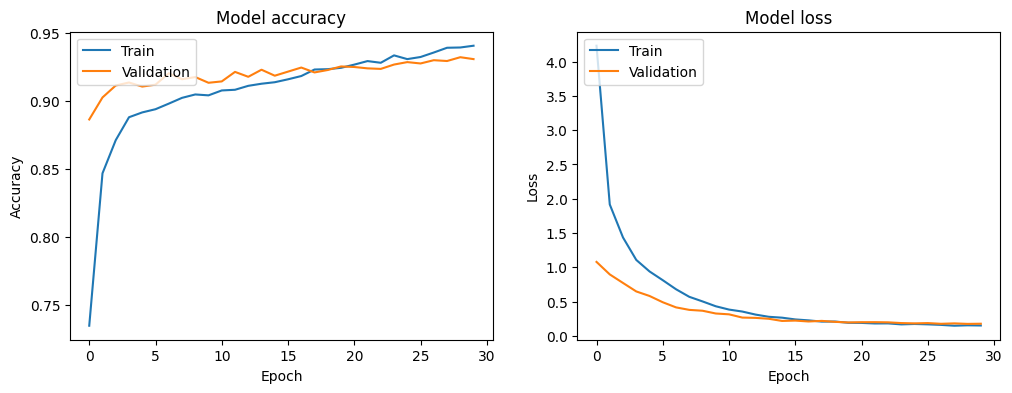

In [19]:
import matplotlib.pyplot as plt

def plot_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

plot_history(history)

In [20]:
model.save("vgg16_dogcat_model.h5")

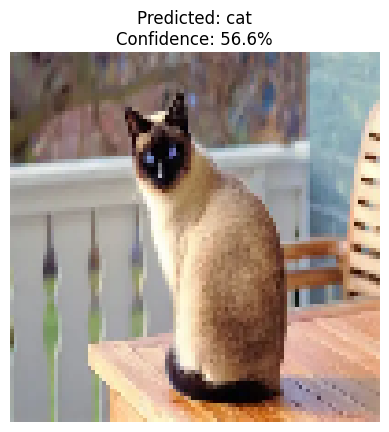


Prediction Result:
- Class: cat
- Confidence: 56.6%
- Raw Probability: 0.5660



In [22]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

def predict_single_image(img_path, model):

    # 1. Load and preprocess image (matches your training)
    img = load_img(img_path, target_size=(100, 100))
    img_array = img_to_array(img)
    img_array = img_to_array(img) / 255.0
    img_batch = np.expand_dims(img_array, axis=0)

    # 2. Predict and interpret
    pred_prob = model.predict(img_batch, verbose=0)[0][0]

    # 3. Class mapping
    class_mapping = {0: 'cat', 1: 'dog'}
    predicted_class = class_mapping[int(pred_prob > 0.5)]
    confidence = max(pred_prob, 1 - pred_prob)  # Always show highest confidence

    # 4. Display results
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_class}\nConfidence: {confidence:.1%}")
    plt.show()

    return {
        'class': predicted_class,
        'confidence': float(confidence),
        'probability': float(pred_prob if predicted_class == 'dog' else 1 - pred_prob)
    }

# Usage:
result = predict_single_image('/content/test_cat.jpeg', model)
print(f"""
Prediction Result:
- Class: {result['class']}
- Confidence: {result['confidence']:.1%}
- Raw Probability: {result['probability']:.4f}
""")